In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
# !pip install databricks-api
from databricks_api import DatabricksAPI
import requests
import json
import datetime as dt
from hdfs import InsecureClient
import xmltodict

In [6]:
dfResult = spark.read.format('xml') \
.options(charset='utf-8')\
.load('/realestate_data/apartment_price/apartment_price_data_201401.xml')

Py4JJavaError: An error occurred while calling o48.load.
: java.lang.ClassNotFoundException: 
Failed to find data source: xml. Please find packages at
http://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:443)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:670)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:720)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:210)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:188)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.ClassNotFoundException: xml.DefaultSource
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:589)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:522)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:656)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:656)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:656)
	... 15 more


In [14]:
file_name = '/realestate_data/apartment_price/apartment_price_data_201401.xml'
df = spark.read.format("com.databricks.spark.xml").option("rowTag", "person").xml("src/main/resources/persons.xml")

AttributeError: 'DataFrameReader' object has no attribute 'xml'

In [5]:
def cal_std_day(befor_day):   
    x = dt.datetime.now() - dt.timedelta(befor_day)
    year = x.year
    month = x.month if x.month >= 10 else '0'+ str(x.month)
    day = x.day if x.day >= 10 else '0'+ str(x.day)  
    return str(year) +str(month) +str(day)

In [4]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic')

## Transform

In [68]:
file_name = '/realestate_data/gender_age/gender_age_data_'+cal_std_day(1)+'.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp2 = tmp.select('result').first()

Row(result=Row(head=Row(returnCode='APIINFO-0001', returnMessage='정상 처리되었습니다.', totalCount='104'), items=Row(item=[Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='19세~29세', resDate='2022-09-27', sex='여자', tot='2'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='30세~39세', resDate='2022-09-27', sex='여자', tot='5'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='40세~49세', resDate='2022-09-27', sex='여자', tot='5'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='50세~59세', resDate='2022-09-27', sex='여자', tot='1'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='60세~69세', resDate='2022-09-27', sex='여자', tot='7'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='70세 이상', resDate='2022-09-27', sex='여자', tot='1'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='30세~39세', resDate='2022-09-27', sex='남자', tot='2'), Row(adminRegn1Name='서울특별시', adminRegn2Name='', bdata_age='40세~49세', resDate='2022-09-27', sex='남자', tot='5'), Row(ad

In [59]:
tmp2 = tmp.select('result')
tmp2.select('items').first()
# tmp3 = tmp2.select('items').first()
# tmp3
df = spark.createDataFrame(tmp2['items'])
df.show()

# df.select(df.gubun.alias('LOC'),df.std)
# tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)

# co_rate = area_popu.join(tmp3, on = 'loc').distinct().orderBy(col('loc'))
# co_rate.show()

AnalysisException: cannot resolve 'item' given input columns: [result];
'Project ['item]
+- Project [result#483]
   +- Relation [result#483] json


### 1. 지역별 단위면적(km)당 인구수와 코로나 확진자 수의 상관관계를 구해보자

In [31]:
# 면적, 인구 정보
area = spark.read.csv('/corona_data/loc/sido_area.csv',encoding='CP949',header=True)
popu = spark.read.csv('/corona_data/loc/sido_population.csv',encoding='CP949',header=True)

area.show(3)
popu.show(3)

+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
|대구|883 |  0.9|
+----+----+-----+
only showing top 3 rows



+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
+----+---------+---------+---------+
only showing top 3 rows



In [34]:
area_popu = area.join(popu, on='loc')
area_popu = area_popu.select(area_popu.loc, ceil(area_popu.total/area_popu.area).alias('popu_density'))
area_popu.show()

+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



In [39]:
# 코로나 감염자 데이터 가져오기
file_name = '/corona_data/patient/corona_patient_2022-09-20.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp.show(3)

+--------------------+---------+------+----------+--------------+----------+
|               items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+--------------------+---------+------+----------+--------------+----------+
|[{1482, 1477989, ...|      500|     1|        00|NORMAL SERVICE|     19912|
+--------------------+---------+------+----------+--------------+----------+



In [42]:
# 지역명과, 10만명 당 감염 현황
tmp2 = tmp.select('items').first()
tmp2
co_patient = spark.createDataFrame(tmp2['items'])
co_patient.show()

# tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
# co_rate = area_popu.join(tmp3, on = 'loc').distinct().orderBy(col('loc'))
# co_rate.show()

Row(items=[Row(deathCnt='1482', defCnt='1477989', gubun='경남', gubunCn='庆南', gubunEn='Gyeongsangnam-do', incDec='2866', isolClearCnt='0', isolIngCnt='0', localOccCnt='2841', overFlowCnt='25', qurRate='44596', stdDay='2022-09-20'), Row(deathCnt='7025', defCnt='6567961', gubun='경기', gubunCn='京畿', gubunEn='Gyeonggi-do', incDec='13316', isolClearCnt='0', isolIngCnt='0', localOccCnt='13288', overFlowCnt='28', qurRate='48417', stdDay='2022-09-20'), Row(deathCnt='1034', defCnt='716414', gubun='강원', gubunCn='江原', gubunEn='Gangwon-do', incDec='1397', isolClearCnt='0', isolIngCnt='0', localOccCnt='1379', overFlowCnt='18', qurRate='46566', stdDay='2022-09-20'), Row(deathCnt='643', defCnt='722686', gubun='광주', gubunCn='光州', gubunEn='Gwangju', incDec='1061', isolClearCnt='0', isolIngCnt='0', localOccCnt='1056', overFlowCnt='5', qurRate='50130', stdDay='2022-09-20'), Row(deathCnt='16', defCnt='13392', gubun='검역', gubunCn='隔離區', gubunEn='Lazaretto', incDec='15', isolClearCnt='0', isolIngCnt='0', local

+--------+-------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt| defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+-------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|    1482|1477989| 경남|   庆南| Gyeongsangnam-do|  2866|           0|         0|       2841|         25|  44596|2022-09-20|
|    7025|6567961| 경기|   京畿|      Gyeonggi-do| 13316|           0|         0|      13288|         28|  48417|2022-09-20|
|    1034| 716414| 강원|   江原|       Gangwon-do|  1397|           0|         0|       1379|         18|  46566|2022-09-20|
|     643| 722686| 광주|   光州|          Gwangju|  1061|           0|         0|       1056|          5|  50130|2022-09-20|
|      16|  13392| 검역| 隔離區|        Lazaretto|    15|           0|         0|          0|         15|   1979|2022-09-20|
|    1599|1063578| 대구

<AxesSubplot:xlabel='popu_density', ylabel='qurRate'>

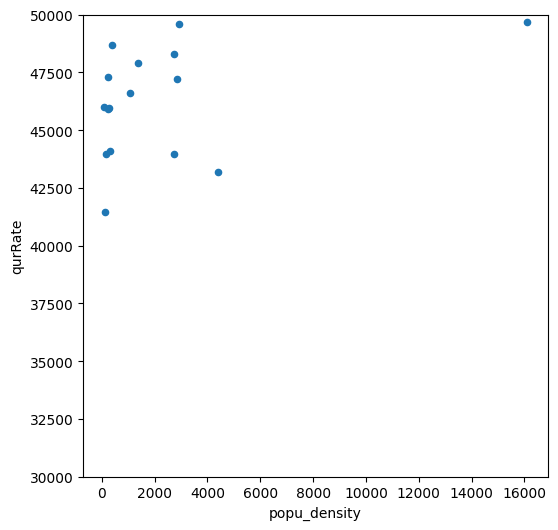

22/09/16 11:17:04 ERROR YarnScheduler: Lost executor 4 on localhost: Executor heartbeat timed out after 327940 ms
22/09/16 11:17:46 ERROR YarnScheduler: Lost executor 3 on localhost: Executor heartbeat timed out after 328746 ms


In [39]:
pd_co = co_rate.toPandas()

pd_co['qurRate'] = pd_co['qurRate'].astype(int)
pd_co.plot(kind='scatter'
           ,x='popu_density'
           ,y='qurRate'
           ,ylim=(30000,50000)
           ,figsize=(6, 6)
          )

### 2.  4차 예방접종 완료자와 코로나 확진자 수의 상관관계를 구해보자

In [19]:
file_name = '/corona_data/vaccine/corona_vaccine_'+cal_std_day(1)+'json'
vaccine = spark.read.json(file_name)
# vaccine.show(3)
vaccine_df = spark.createDataFrame(vaccine.select('data').first()['data'])
# vaccine_df.show()
# pop_vaccine = vaccine_df.join(popu, on='loc').select(vaccine_df.loc,ceil((vaccine_df.v4/popu.total)*100).alias('v_rate'))
pop_vaccine = vaccine_df.join(popu,on='loc').select('loc',col('v4'),col('total'),
                                                   ceil((col('v4')/col('total')*100)).alias('v_rate'))
# pop_vaccine.show()

tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
co_vaccine_df = pop_vaccine.join(tmp3, on='loc')
# co_vaccine_df.show()
co_vaccine = co_vaccine_df.select('loc','v_rate','qurRate').distinct()
co_vaccine_df.show()

+----+-------+---------+------+-------+
| loc|     v4|    total|v_rate|qurRate|
+----+-------+---------+------+-------+
|강원| 269222| 1555876 |    18|  45979|
|강원| 269222| 1555876 |    18|  45979|
|강원| 269222| 1555876 |    18|  45979|
|강원| 269222| 1555876 |    18|  45979|
|경기|1680362|13925862 |    13|  47883|
|경기|1680362|13925862 |    13|  47883|
|경기|1680362|13925862 |    13|  47883|
|경기|1680362|13925862 |    13|  47883|
|경남| 483703| 3377331 |    15|  44098|
|경남| 483703| 3377331 |    15|  44098|
|경남| 483703| 3377331 |    15|  44098|
|경남| 483703| 3377331 |    15|  44098|
|경북| 394769| 2677709 |    15|  41475|
|경북| 394769| 2677709 |    15|  41475|
|경북| 394769| 2677709 |    15|  41475|
|경북| 394769| 2677709 |    15|  41475|
|광주| 233610| 1462545 |    16|  49604|
|광주| 233610| 1462545 |    16|  49604|
|광주| 233610| 1462545 |    16|  49604|
|광주| 233610| 1462545 |    16|  49604|
+----+-------+---------+------+-------+
only showing top 20 rows



<AxesSubplot:xlabel='v_rate', ylabel='qurRate'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


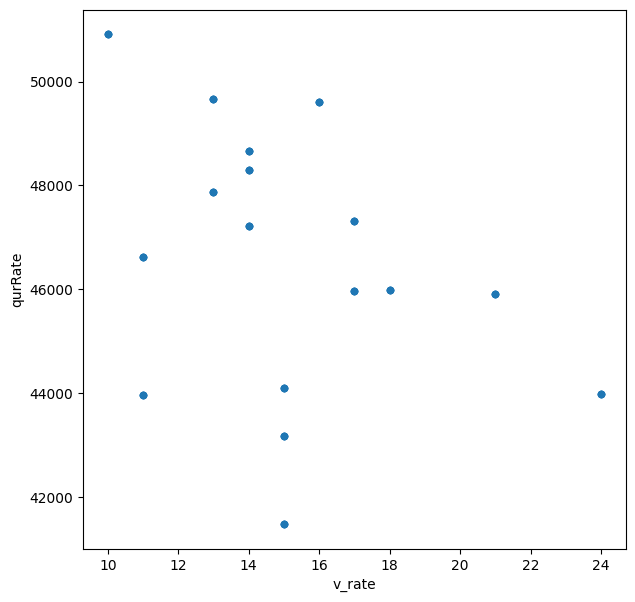

In [20]:
pd_vac = co_vaccine_df.toPandas()

pd_vac['qurRate'] = pd_vac['qurRate'].astype(int)
pd_vac.plot(kind='scatter'
           ,x='v_rate'
           ,y='qurRate'
           ,figsize=(7, 7)
          )

### 3. 다중이용시설과 코로나 확진자 수의 상관관계

In [87]:
# file_name = '/corona_data/loc/corona_vaccine_'+cal_std_day(1)+'json'
facility = spark.read.csv('/corona_data/loc/전국다중이용시설.csv',encoding='CP949',header=True)
facility.show(3)
sido = spark.read.csv('/corona_data/loc/sido_area.csv',encoding='CP949',header=True)
sido.show(3)
sido_popu = spark.read.csv('/corona_data/loc/sido_population.csv',encoding='CP949',header=True)
sido_popu.show(3)

+----+----+------+----------------+--------------+--------+
|연도|광역|시군구|          시설명|사업자등록번호|  시설군|
+----+----+------+----------------+--------------+--------+
|2020|강원|강릉시|(주)경포솔향온천|  127-86-57613|  목욕장|
|2020|강원|강릉시|  24시황실사우나|  226-33-03247|  목욕장|
|2020|강원|강릉시|    강릉고려병원|  226-82-03662|의료기관|
+----+----+------+----------------+--------------+--------+
only showing top 3 rows



+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
|대구|883 |  0.9|
+----+----+-----+
only showing top 3 rows



+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
+----+---------+---------+---------+
only showing top 3 rows



In [150]:
######### 풀이
fac_cnt = facility.groupBy(facility.광역.alias('loc')).agg(count('*').alias('fac_cnt'))
# fac_cnt.show()
tmp = popu.join(fac_cnt, on ='loc')
fac_popu = tmp.select('loc', ceil(tmp.fac_cnt/tmp.total*100000).alias('fac_popu'))

tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
fac_rate = fac_popu.join(tmp3, on='loc')
fac_rate.show()

+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|강원|      38|  45979|
|강원|      38|  45979|
|강원|      38|  45979|
|강원|      38|  45979|
|경기|      46|  47883|
|경기|      46|  47883|
|경기|      46|  47883|
|경기|      46|  47883|
|경남|      41|  44098|
|경남|      41|  44098|
|경남|      41|  44098|
|경남|      41|  44098|
|경북|      36|  41475|
|경북|      36|  41475|
|경북|      36|  41475|
|경북|      36|  41475|
|광주|      51|  49604|
|광주|      51|  49604|
|광주|      51|  49604|
|광주|      51|  49604|
+----+--------+-------+
only showing top 20 rows



<AxesSubplot:xlabel='fac_popu', ylabel='qurRate'>

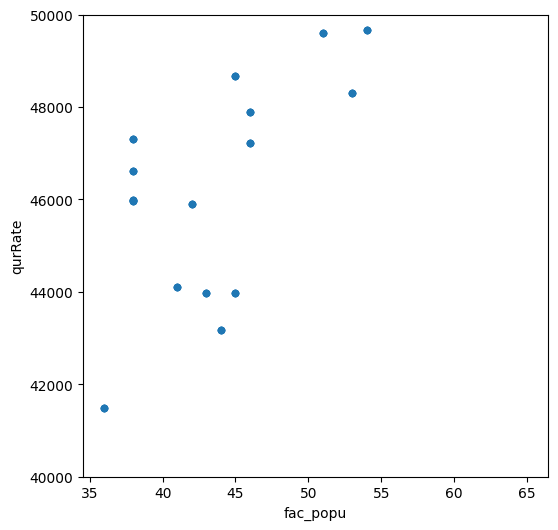

In [154]:
pd_fac = fac_rate.toPandas()
pd_fac['qurRate'] = pd_fac['qurRate'].astype(int)
pd_fac.plot(kind='scatter'
           ,x='fac_popu'
           ,y='qurRate'
           ,ylim=(40000,50000)
           ,figsize=(6, 6) 
          )

In [157]:
facility_df = facility.groupBy(facility.광역).agg({'시설군':'count'})
##### df로 불러올때부터 alias설정 : facility.광역.alias('loc'), agg(count(*).alias('fac_cnt'))
# facility_df = facility.groupBy(facility.광역.alias('loc')).agg(count('*').alias('fac_cnt'))
facility_df.show()

+----+-------------+
|광역|count(시설군)|
+----+-------------+
|경북|          944|
|대전|          767|
|전북|          759|
|충북|          617|
|울산|          431|
|경남|         1357|
|제주|          310|
|충남|          824|
|전남|          825|
|인천|         1386|
|부산|         1462|
|대구|         1015|
|경기|         6303|
|서울|         5224|
|광주|          732|
|세종|          243|
|강원|          584|
+----+-------------+



In [146]:
tmp = sido_popu.select(col('loc').alias('광역'),col('total'))
fac_popu = facility_df.join(tmp, on='광역')
fac_popu_df = fac_popu.select(fac_popu.광역.alias('loc'), ceil(col('count(시설군)')/col('total')*100000).alias('fac_popu'))
fac_popu_df.show()

+----+--------+
| loc|fac_popu|
+----+--------+
|경북|      36|
|대전|      53|
|전북|      42|
|충북|      38|
|울산|      38|
|경남|      41|
|제주|      45|
|충남|      38|
|전남|      45|
|인천|      46|
|부산|      44|
|대구|      43|
|경기|      46|
|서울|      54|
|광주|      51|
|세종|      65|
|강원|      38|
+----+--------+



### 4. 요일별 코로나 확진자 수를 구해보자

In [197]:
file_name = '/corona_data/patient/'
tmp = spark.read.json(file_name, encoding='UTF-8')
p = patient_data.withColumn('dayofweek',dayofweek(patient_data.stdDay))
# p.show()

# localOccCnt -> 당일 발생한 코로나 확진자 수 - 해외유입수
p_df = p.groupBy(p.dayofweek).agg(sum(col('localOccCnt')).alias('patients')).orderBy(col('dayofweek'))
p_df.show()


+---------+---------+
|dayofweek| patients|
+---------+---------+
|        1|2371132.0|
|        2|1344660.0|
|        3|3063232.0|
|        4|3862608.0|
|        5|3559088.0|
|        6|2892264.0|
|        7|2647380.0|
+---------+---------+



<AxesSubplot:>

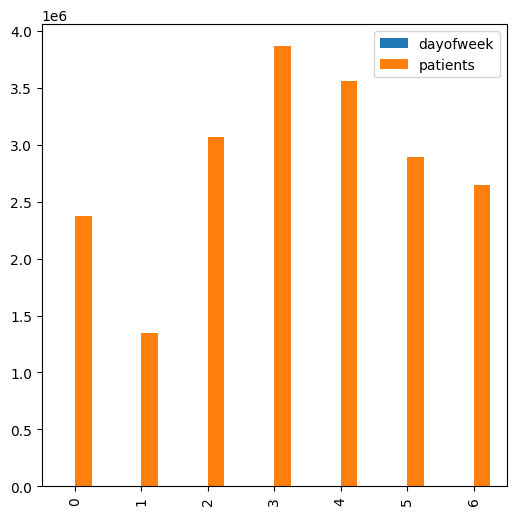

In [198]:
pd_week = p_df.toPandas()
pd_week.plot(kind='bar', figsize=(6, 6))

In [166]:
tmp.select(tmp.items).show()

+----------------------+
|                 items|
+----------------------+
|[{16, 12659, 검역, ...|
|  [{1465, 1461477, ...|
|[{16, 12440, 검역, ...|
| [{1043, 868166, 충...|
|  [{1429, 1214957, ...|
|[{528, 687990, 전남...|
|  [{26161, 22449475...|
|  [{25441, 20983169...|
| [{1376, 847452, 대...|
|[{520, 666170, 전남...|
|  [{5077, 4264423, ...|
|  [{6778, 6219245, ...|
| [{1375, 842746, 대...|
|  [{2268, 1266446, ...|
| [{1475, 996824, 대...|
|  [{2249, 1204102, ...|
|[{781, 679100, 충북...|
|[{755, 648957, 대전...|
|[{883, 571175, 강원...|
|  [{1427, 1196686, ...|
+----------------------+
only showing top 20 rows



In [180]:
data = []
for r1 in tmp.select(tmp.items).toLocalIterator():
    if not r1.items:
        continue
    for r2 in r1.items:
        data.append(r2)
        
patient_data = spark.createDataFrame(data)
patient_data.show()

+--------+--------+-----+-------+----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt|  defCnt|gubun|gubunCn|         gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+--------+-----+-------+----------------+------+------------+----------+-----------+-----------+-------+----------+
|      16|   12659| 검역| 隔離區|       Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|
|      16|   12659| 검역| 隔離區|       Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|
|    6715| 6109867| 경기|   京畿|     Gyeonggi-do| 27032|           0|         0|      27007|         25|  45040|2022-08-25|
|    5165| 4475520| 서울|   首尔|           Seoul| 17722|           0|         0|      17707|         15|  47064|2022-08-25|
|     927|  763330| 전북|   全北|    Jeollabuk-do|  4533|           0|         0|       4482|         51|  42719|2022-08-25|
|    5165| 4475520| 서울